<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/WithThremoclineAnalysis_ConstrainedWaterMassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cvxpy as cp

In [2]:
!pip install gsw

     |████████████████████████████████| 2.4MB 6.1MB/s 


In [3]:
import gsw

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2020-11-16 16:09:25--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 172.217.204.138, 172.217.204.100, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rbc3giungv65l7k97i2gjop8hkttll88/1605542925000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2020-11-16 16:09:26--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rbc3giungv65l7k97i2gjop8hkttll88/1605542925000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s

In [5]:
def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

In [6]:
import pandas as pd
import numpy as np

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
              "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.02

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [7]:

gp15_df["PO"]

0       352.55
2       383.61
3       401.95
4       411.28
5       432.26
         ...  
1137    527.97
1138    531.52
1139    536.65
1140    539.28
1141    536.76
Name: PO, Length: 926, dtype: float64

In [8]:

def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


In [9]:
from collections import OrderedDict


import scipy
import scipy.spatial


def spherical_to_surface_cartesian(lat, lon):
    r = 6.371*(1E3) #earth radius
    theta = ((1-lat)/180.0)*np.pi
    phi = (lon/180.0)*np.pi
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    return (x,y)


def add_surface_cartesian_coordinates_to_df(df):
    latitudes = df["latitude"]
    longitudes = df["longitude"]
    xs,ys = list(zip(*[spherical_to_surface_cartesian(*x)
                       for x in zip(latitudes, longitudes)]))
    df["x"] = xs
    df["y"] = ys
    #plt.scatter(xs, ys)
    #plt.show()


def compute_pairwise_distances_depthmetric(df, depth_metric, depth_scale):
    xs = df["x"]
    ys = df["y"]
    
    depth_metric = np.array(df[depth_metric])
    depth_diffs = np.abs(depth_metric[:,None] -
                         depth_metric[None,:])*depth_scale

    #plt.hist(depth_diffs.ravel(), bins=20)
    #plt.show()

    coors = np.array([xs, ys]).transpose((1,0))
    euclidean_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(coors))
    #plt.hist(euclidean_distances.ravel(), bins=100)
    #plt.show()

    weighted_distances = np.sqrt(np.square(euclidean_distances)
                                 + np.square(depth_diffs))
    #plt.hist(weighted_distances.ravel(), bins=20)
    #plt.show()
    return weighted_distances


def make_pairs_matrix(obs_df, depth_metric, depth_scale, nneighb):
    obs_df = pd.DataFrame(obs_df)
    add_surface_cartesian_coordinates_to_df(obs_df)
    pairwise_distances = compute_pairwise_distances_depthmetric(
        obs_df, depth_metric=depth_metric, depth_scale=depth_scale)
    #plt.hist(pairwise_distances.ravel(), bins=20)
    #plt.show()
    nneighb_thresh = np.sort(pairwise_distances, axis=-1)[:,nneighb]
    masked_pairwise_distances =\
      (pairwise_distances*(pairwise_distances <= nneighb_thresh[:,None])
                         *(pairwise_distances > 0))
    pairs_to_consider_indices = np.nonzero(masked_pairwise_distances)
    print("Constrained pairs:",len(pairs_to_consider_indices[0]))
    pairs_distances = pairwise_distances[
        pairs_to_consider_indices[0],
        pairs_to_consider_indices[1]]
    #plt.hist(pairs_distances.ravel(), bins=20)
    #plt.show()
    pairs_matrix = np.zeros((len(pairs_to_consider_indices[0]),
                              len(obs_df)))
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[0]] = 1.0/nneighb#(
                      #1/pairs_distances)
    pairs_matrix[np.arange(len(pairs_distances)),
                  pairs_to_consider_indices[1]] = -1.0/nneighb#(
                      #1/pairs_distances)
    return pairs_matrix


class OMPAProblem(object):

    def __init__(self, watermass_df, obs_df, paramsandweighting,
                       smoothness_lambda):
        self.watermass_df = watermass_df
        self.obs_df = obs_df
        self.paramsandweighting = paramsandweighting
        #split up the paramsandweighting into params and weighting
        self.params_to_use, self.weighting = [list(x) for x in 
                                              zip(*paramsandweighting)]
        self.smoothness_lambda = smoothness_lambda

    def core_solve(self, A, b, pairs_matrix, verbose=True):
        #We are going to solve the following problem:
        # Minimize (x A - b)^2
        # Subject to x >= 0, cp.sum(x, axis=1) == 1
        # x has dimensions of observations X end_members
        # A has dimensions of end_members X parameteres
        # b has dimensions of observations X parameters
       
        x = cp.Variable(shape=(len(b), len(A)))
        obj = cp.sum_squares(x@A - b)
        if (self.smoothness_lambda is not None):
            obj += self.smoothness_lambda*cp.sum_squares(pairs_matrix@x)
        obj = cp.Minimize(obj)
        
        constraints = [x >= 0, cp.sum(x,axis=1)==1]
        prob = cp.Problem(obj, constraints)
        prob.solve(verbose=False, max_iter=50000)
        #settign verbose=True will generate more print statements and slow down the analysis
        
        print("status:", prob.status)
        print("optimal value", prob.value)

        if (prob.status=="infeasible"):
            water_mass_fractions = None
            residuals_squared = None
        else:
          water_mass_fractions = x.value
          residuals_squared = np.sum(
              np.square((water_mass_fractions@A) - b), axis=-1)
        
        return water_mass_fractions, residuals_squared, prob

    def solve(self):

        watermass_df = self.watermass_df
        obs_df = pd.DataFrame(self.obs_df)
        params_to_use = self.params_to_use
        weighting = np.array(self.weighting)
            
        A = np.array(watermass_df[params_to_use])
        b = np.array(obs_df[params_to_use])
        
        print("params to use:", params_to_use)
        print("param weighting:", weighting)
        A = A*weighting[None,:]
        b = b*weighting[None,:]

        if (self.smoothness_lambda is not None):
            pairs_matrix = make_pairs_matrix(
              obs_df=obs_df,
              depth_metric="depth",
              depth_scale=1.0,
              nneighb=4)
        else:
            pairs_matrix = None

        water_mass_fractions, residuals_squared, prob = self.core_solve(
            A=A, b=b, pairs_matrix=pairs_matrix)      
        self.prob = prob    
        
        if (water_mass_fractions is not None):
            print("objective:", np.sum(residuals_squared))
            param_reconstruction = (water_mass_fractions@A)/weighting[None,:]
            param_residuals = b/weighting[None,:] - param_reconstruction

            self.water_mass_fractions = water_mass_fractions
            self.param_reconstruction = param_reconstruction
            self.param_residuals = param_residuals


gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 26.6)
                            & (gp15_df["sig0"] <= 27.72)]

intermediate_paramsandweighting = [("potential_temp",140),
                                   ("practical_salinity",100),
                                   ("silicate",30),
                                   ("NO",10),
                                   #("PO",10),
                                   ("spiciness",10),
                                   #("PV",10),
                                   ]

intermediate_paramsandweighting_nospicy = [("potential_temp",140),
                                   ("practical_salinity",100),
                                   ("silicate",30),
                                   ("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ]

intermediate_paramsandweighting2 = [("potential_temp",140),
                                   ("practical_salinity",100),
                                   ("silicate",30),
                                   ("NO",10),
                                   ("PO",10),
                                   ("spiciness",10),
                                   #("PV",10),
                                   ]

watermassdfname_to_dfs = OrderedDict()  
watermassdfname_to_dfs['intermediate'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23
                          ]),
   gp15_intermediate)
  
watermassdfname_to_dfs['intermediate_withEqPIW'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_EqPIW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23
                          ]),
   gp15_intermediate)


ompa_setting_to_soln = OrderedDict()
for watermassdfname, (watermass_df, obs_df) in watermassdfname_to_dfs.items():
    for (weightingname, weighting) in [
             ("weighting_withoutPO", intermediate_paramsandweighting),
             ("weighting_withoutPO_nospicy", intermediate_paramsandweighting_nospicy),
             ("weighting_withPO", intermediate_paramsandweighting2)
             ]:
        for smoothness_lambda in [None]:#, 10000, 100000, 1000000]:
            print(watermassdfname, weightingname)
            ompa_problem = OMPAProblem(
              watermass_df = watermass_df,
              obs_df = obs_df,
              paramsandweighting=weighting,
              smoothness_lambda=smoothness_lambda)
            ompa_problem.solve()
            ompa_setting_to_soln[(watermassdfname,
                                  smoothness_lambda,
                                  weightingname)] = ompa_problem


intermediate weighting_withoutPO
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness']
param weighting: [140 100  30  10  10]
status: optimal
optimal value 1338628.2015885976
objective: 1338628.2040988726
intermediate weighting_withoutPO_nospicy
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO']
param weighting: [140 100  30  10]
status: optimal
optimal value 1338319.0825509808
objective: 1338319.0949823218
intermediate weighting_withPO
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'PO', 'spiciness']
param weighting: [140 100  30  10  10  10]
status: optimal
optimal value 3114566.858686383
objective: 3114566.861249759
intermediate_withEqPIW weighting_withoutPO
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness']
param weighting: [140 100  30  10  10]
status: optimal
optimal value 1338632.1372110434
objective: 1338632.1375815058
intermediate_withEqPIW weighting_withoutPO

Plotting water mass fractions
Setting: ('intermediate', None, 'weighting_withoutPO')


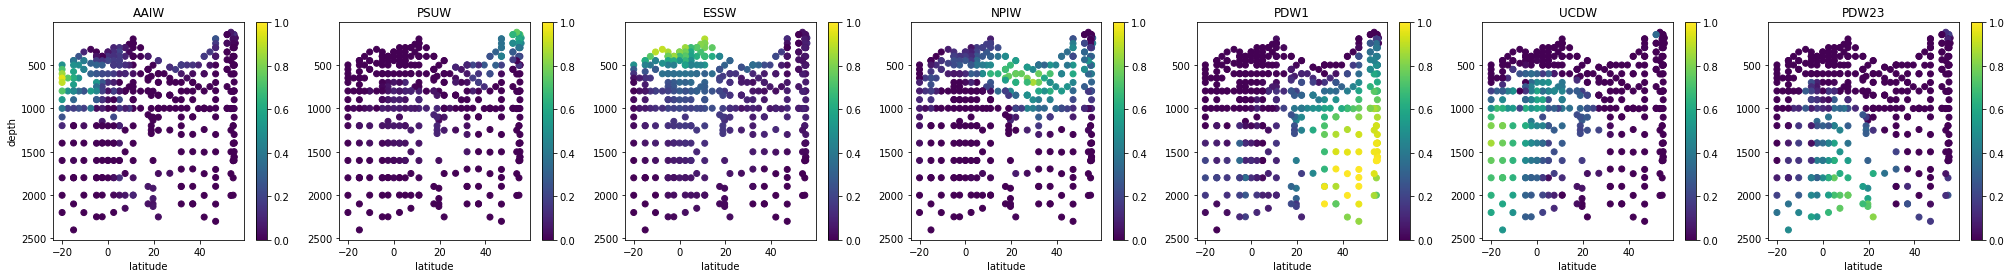

Setting: ('intermediate', None, 'weighting_withoutPO_nospicy')


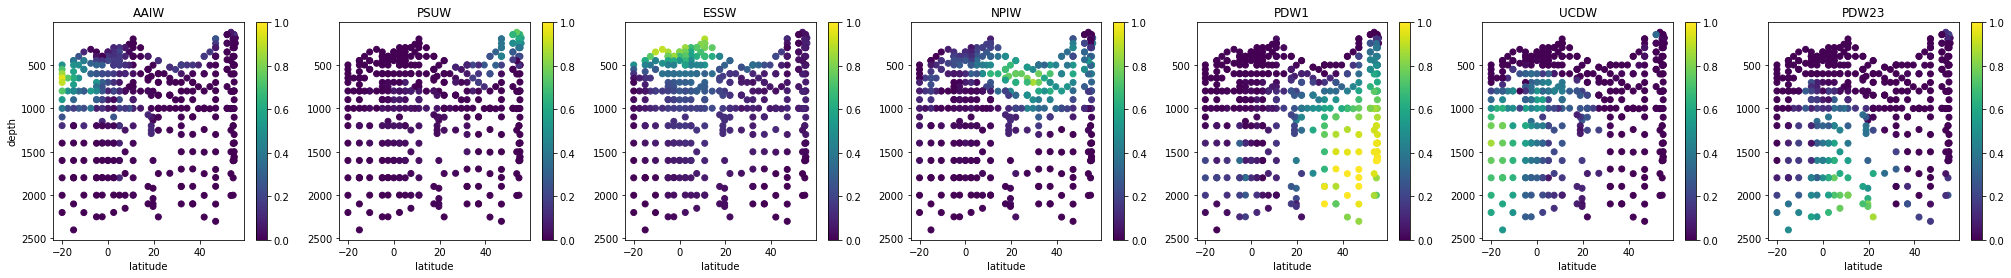

Setting: ('intermediate', None, 'weighting_withPO')


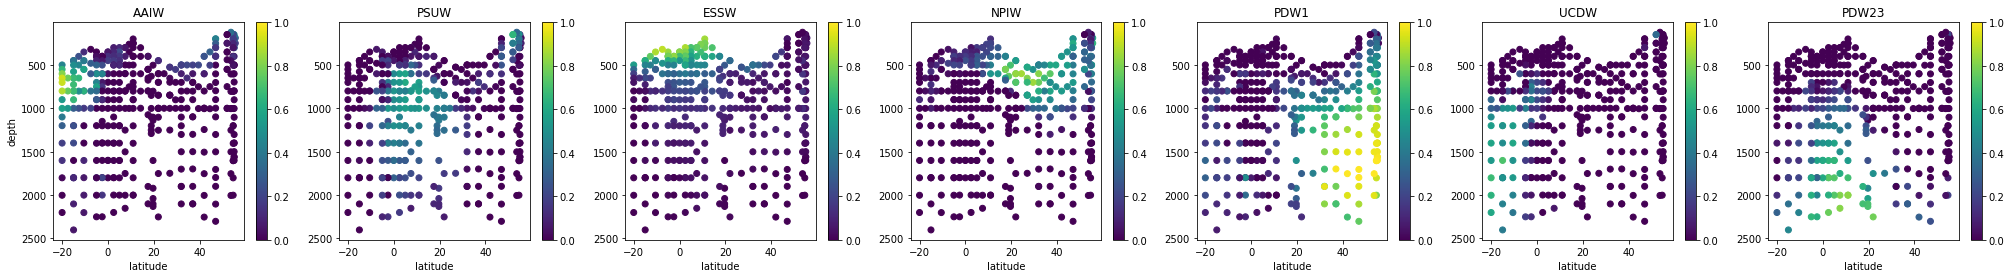

Setting: ('intermediate_withEqPIW', None, 'weighting_withoutPO')


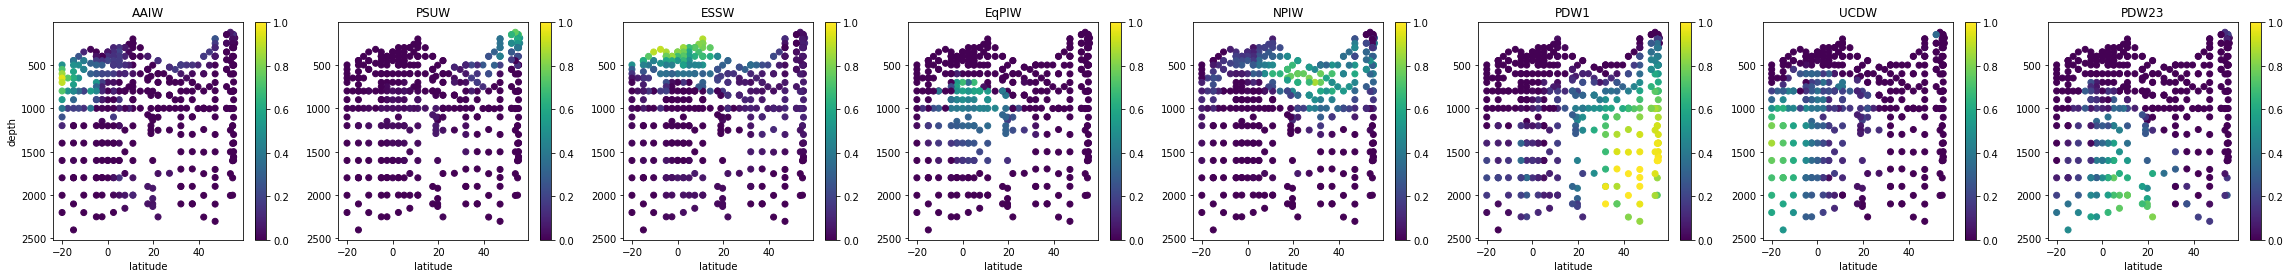

Setting: ('intermediate_withEqPIW', None, 'weighting_withoutPO_nospicy')


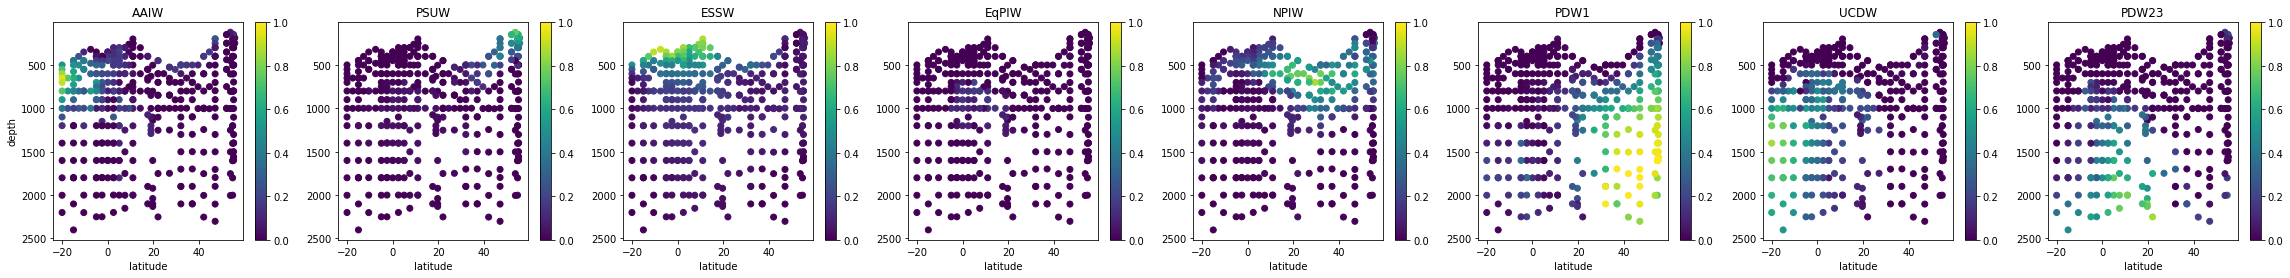

Setting: ('intermediate_withEqPIW', None, 'weighting_withPO')


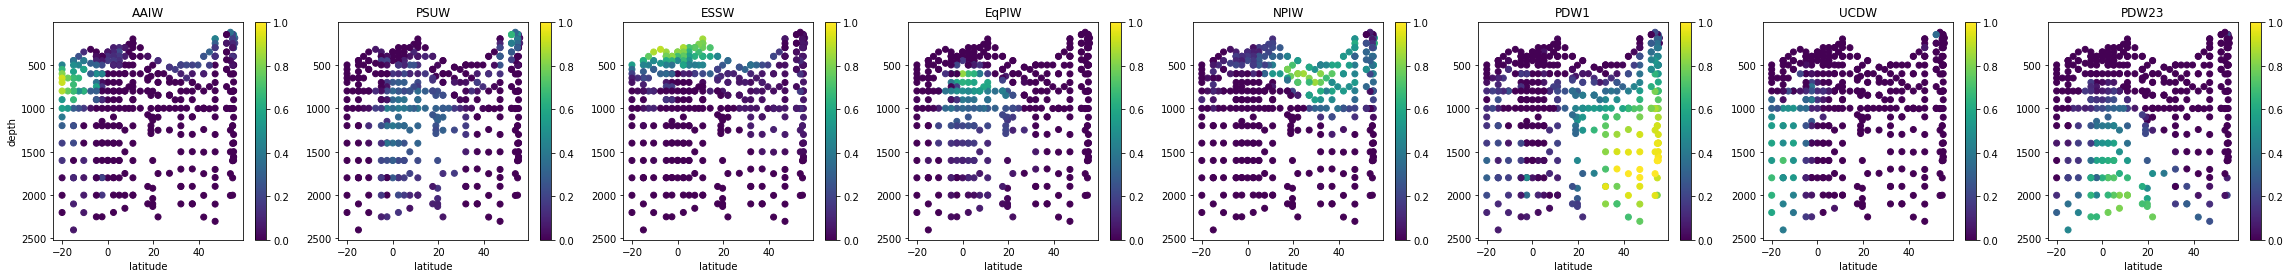

Plotting absolute residuals
Setting: ('intermediate', None, 'weighting_withoutPO')


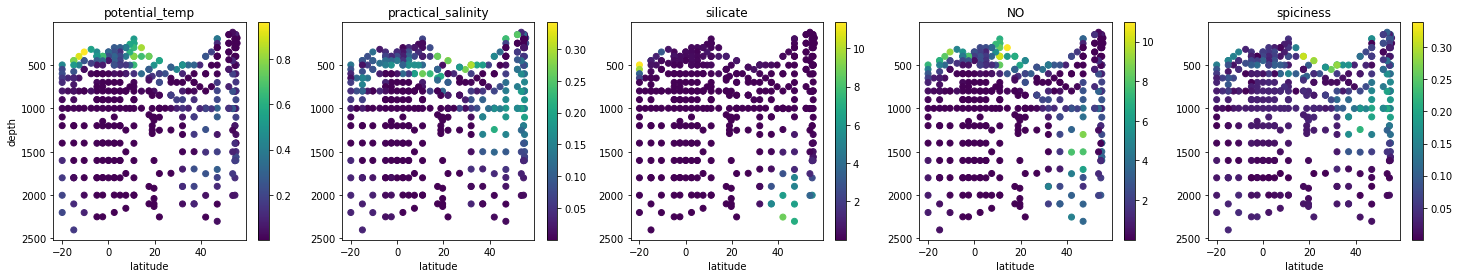

Setting: ('intermediate', None, 'weighting_withoutPO_nospicy')


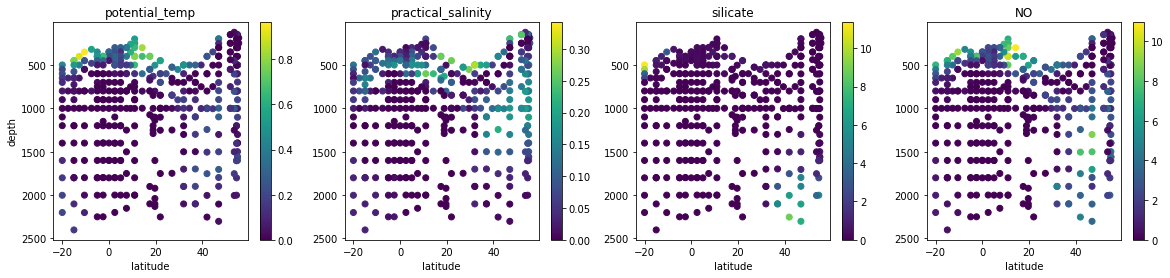

Setting: ('intermediate', None, 'weighting_withPO')


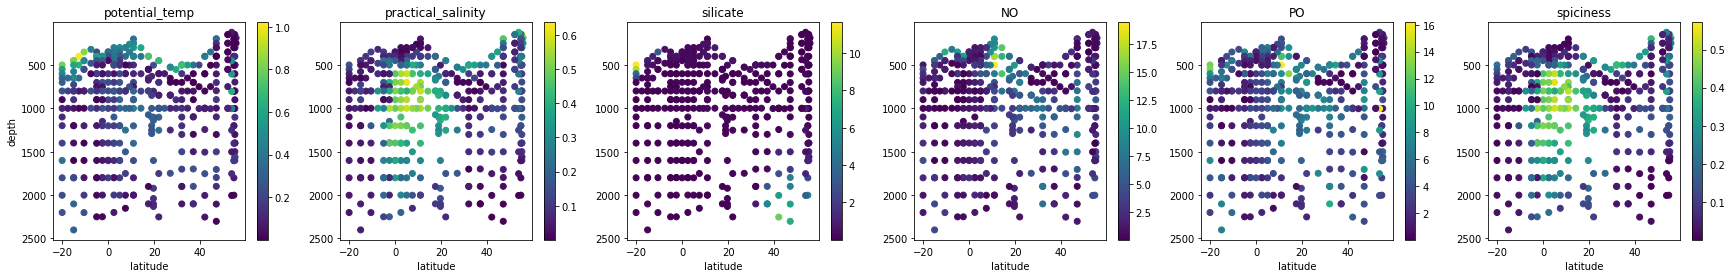

Setting: ('intermediate_withEqPIW', None, 'weighting_withoutPO')


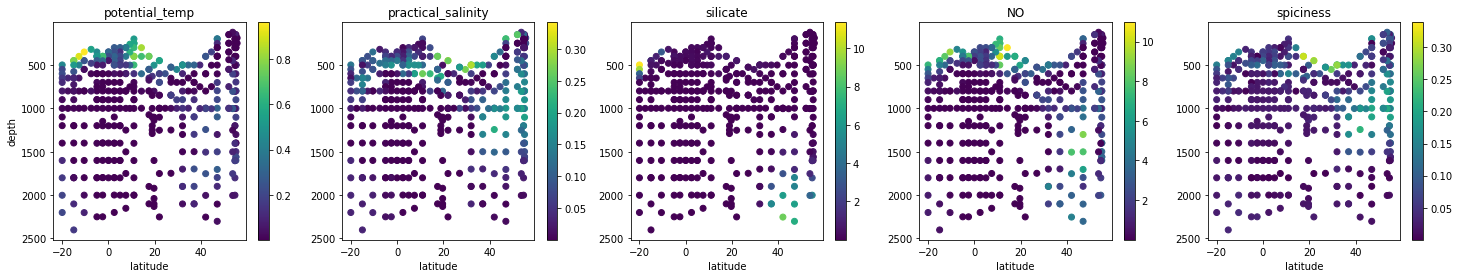

Setting: ('intermediate_withEqPIW', None, 'weighting_withoutPO_nospicy')


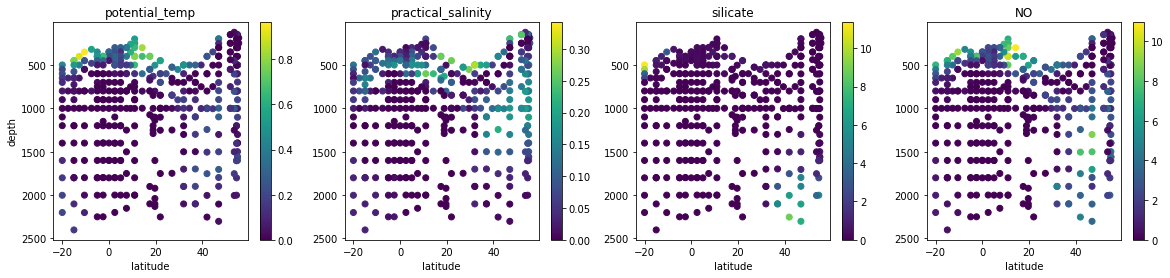

Setting: ('intermediate_withEqPIW', None, 'weighting_withPO')


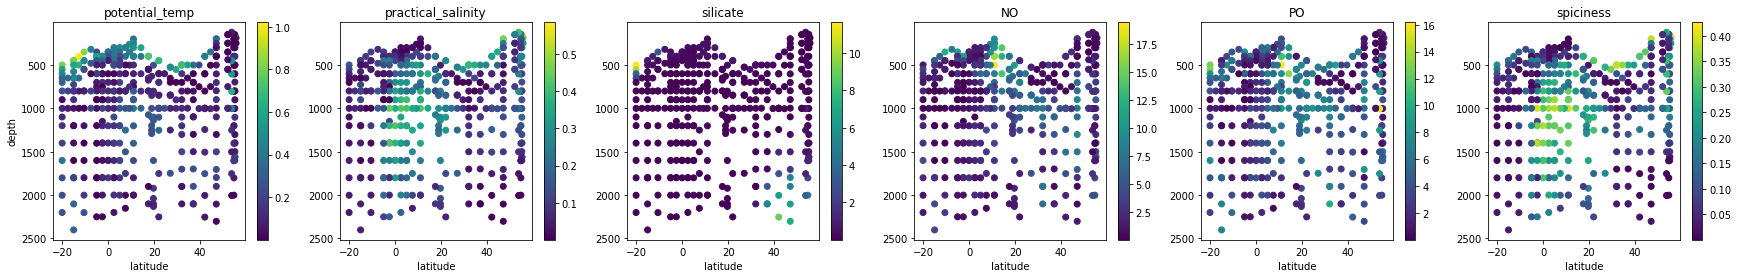

In [10]:
from matplotlib import pyplot as plt


def plot_water_mass_fractions(ompa_problem, yaxis="depth"):
    num_watermasses = ompa_problem.water_mass_fractions.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df[yaxis],
                    c=ompa_problem.water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])
    plt.show()


def plot_residuals(ompa_problem):
    num_params = ompa_problem.param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    for i in range(ompa_problem.param_residuals.shape[1]):
        plt.sca(ax[i])
        plt.scatter(x=ompa_problem.obs_df["latitude"],
                    y=ompa_problem.obs_df["depth"],
                    c=np.abs(ompa_problem.param_residuals[:,i]),
                    cmap="viridis")
        plt.colorbar()
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.title(ompa_problem.params_to_use[i])
    plt.show()


print("Plotting water mass fractions")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_water_mass_fractions(ompa_setting_to_soln[setting])

print("Plotting absolute residuals")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_residuals(ompa_setting_to_soln[setting])  

In [36]:
import altair as alt
#Build an interactive visualization

CHART_WIDTH=200
CHART_HEIGHT=200
FONTSIZE=10
ROWSIZE=7

def nozero_xaxis(field_name):
  return alt.X(field_name, scale=alt.Scale(zero=False))


def nozero_yaxis(field_name, domain=None):
  if (domain is None):
    return alt.Y(field_name, scale=alt.Scale(zero=False))
  else:
    return alt.Y(field_name, scale=alt.Scale(zero=False, domain=domain))


def latdepth_scatterplot(basechart, selection,
                         property_name, altairdf, zerocenter=False):
    additional_color_kwargs = {}
    if (zerocenter):
        max_abs_property = np.max(np.abs(altairdf[property_name]))
        scale = alt.Scale(scheme='blueorange',
                          domain=[-max_abs_property, max_abs_property])
        additional_color_kwargs['scale'] = scale
    color = alt.condition(selection, property_name, alt.value('lightgray'),
                          title="",
                          **additional_color_kwargs)
    max_depth = np.max(altairdf["depth"])*1.05
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis("depth", domain=(max_depth,0))
           ).encode(color=color).properties(title=property_name)
    return to_return
           

def wrap_scatterplots(scatterplots, resolve_scale='shared'):
    hconcats = [
        alt.hconcat(*scatterplots[i:i+ROWSIZE]).resolve_scale(
            color=resolve_scale)
        for i in range(0,len(scatterplots), ROWSIZE)  
    ]
    return alt.vconcat(*hconcats)


def pp_scatterplot(obs_basechart, selection,
                   watermass_basechart,
                   property1, property2, opacity):
    color = alt.condition(selection, alt.value('lightblue'),
                          alt.value('lightgray'))
    return (obs_basechart.mark_point(opacity=opacity).encode(
                nozero_xaxis(property1),
                nozero_yaxis(property2),
                color=color)
            + watermass_basechart.encode(nozero_xaxis(property1),
                                         nozero_yaxis(property2)))
    

def build_altair_viz(ompa_problem):
    altairdf = pd.DataFrame(ompa_problem.obs_df)
    watermass_names = []
    for water_mass_idx in range(ompa_problem.water_mass_fractions.shape[1]):
      watermass_name =\
        ompa_problem.watermass_df["watermassname"][water_mass_idx]
      watermass_names.append(watermass_name)
      altairdf[watermass_name] =\
          ompa_problem.water_mass_fractions[:,water_mass_idx]

    for param_idx in range(ompa_problem.param_residuals.shape[1]):
        param_name = ompa_problem.params_to_use[param_idx]
        altairdf[param_name+"_resid"] =\
          ompa_problem.param_residuals[:,param_idx]

    interval_selection = alt.selection_interval()
    tooltip_columns = (ompa_problem.params_to_use
                       + ["latitude", "longitude"]
                       + watermass_names
                       + [x+"_resid" for x in ompa_problem.params_to_use])
    #make the linked property-property plots
    obs_basechart = alt.Chart(altairdf).mark_point().encode(
      tooltip=tooltip_columns,
      color=alt.condition(interval_selection,
                          alt.value("lightblue"),#"NPIW",
                          alt.value('lightgray'))
      ).add_selection(interval_selection).properties(
          width=CHART_WIDTH,
          height=CHART_HEIGHT)
    
    watermass_basechart =\
      alt.Chart(ompa_problem.watermass_df).mark_point(
          shape="diamond", size=50).encode(
              color="watermassname").properties(
                width=CHART_WIDTH,
                height=CHART_HEIGHT)

    #display a row that is the water mass fractions
    watermass_fraction_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf)
        for property_name in watermass_names]

    the_pp_scatterplots = []
    for i in range(len(ompa_problem.params_to_use)):
        for j in range(i+1,len(ompa_problem.params_to_use)):
            the_pp_scatterplots.append(
                pp_scatterplot(
                    obs_basechart=obs_basechart,
                    selection=interval_selection,
                    watermass_basechart=watermass_basechart,
                    property1=ompa_problem.params_to_use[i],
                    property2=ompa_problem.params_to_use[j],
                    opacity=0.2)
            )
    
    resid_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name+"_resid",
            altairdf=altairdf,
            zerocenter=True)
        for property_name in ompa_problem.params_to_use]

    prop_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf,
            zerocenter=True)
        for property_name in ompa_problem.params_to_use]

    return alt.vconcat(
              wrap_scatterplots(watermass_fraction_scatterplots),
              wrap_scatterplots(prop_scatterplots, resolve_scale="independent"),
              wrap_scatterplots(resid_scatterplots,
                                resolve_scale='independent'),
              wrap_scatterplots(the_pp_scatterplots))

build_altair_viz(ompa_setting_to_soln[
  ('intermediate_withEqPIW', None, 'weighting_withPO')])

alt.VConcatChart(...)

In [12]:


def latdepth_scatter2(basechart, property_name, depth_metric):
    max_depth = np.max(basechart.data[depth_metric])*1.00
    min_depth = np.min(basechart.data[depth_metric])*1.00
    to_return = basechart.encode(
              nozero_xaxis("latitude"),
              nozero_yaxis(depth_metric, domain=(max_depth,min_depth))
           ).encode(color=property_name).properties(title=property_name)
    return to_return


def plot_penalty(perobs_diffmagsum, ompa_problem, depth_metric):
    watermass_names = list(ompa_problem.watermass_df["watermassname"])
    altair_df = pd.DataFrame(
        perobs_diffmagsum,
        columns=[x+"_penalty" for x in watermass_names])
    altair_df["latitude"] = np.array(ompa_problem.obs_df["latitude"])
    altair_df["longitude"] = np.array(ompa_problem.obs_df["longitude"])
    altair_df["depth"] = np.array(ompa_problem.obs_df["depth"])
    altair_df["sig0"] = np.array(ompa_problem.obs_df["sig0"])
    for watermass_idx,watermass_name in enumerate(watermass_names):
      altair_df[watermass_name] =\
        ompa_problem.water_mass_fractions[:,watermass_idx]
    altair_df["obs_idx"] = np.arange(len(ompa_problem.obs_df)) 

    tooltip_columns = (["obs_idx", "latitude", "longitude", "sig0"]
                       + watermass_names
                       + [x+"_penalty" for x in watermass_names])
    basechart = alt.Chart(altair_df).mark_point().encode(
                  tooltip=tooltip_columns).properties(
                    width=CHART_WIDTH,
                    height=CHART_HEIGHT)
    
    watermass_frac_scatterplots = [
       latdepth_scatter2(basechart, property_name,
                         depth_metric=depth_metric)
       for property_name in watermass_names]
    penalty_scatterplots = [
      latdepth_scatter2(basechart, property_name+"_penalty",
                        depth_metric=depth_metric)
      for property_name in watermass_names]

    return alt.vconcat(
            wrap_scatterplots(watermass_frac_scatterplots),
            wrap_scatterplots(penalty_scatterplots, resolve_scale="independent"))
    
    #print(altair_df)


def compute_perobs_smoothnesspenalty(ompa_problem,
                                     depth_metric="depth",
                                     depth_scale=1):
    intanddeep_pairsmatrix = make_pairs_matrix(
        obs_df=ompa_problem.obs_df,
        depth_metric=depth_metric,
        depth_scale=depth_scale,
        nneighb=4)
    
#    diff_mag_squared = (
#        np.maximum(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions,0))
    diff_mag_squared = (
        np.square(intanddeep_pairsmatrix@ompa_problem.water_mass_fractions))
    obs_to_relatedpairs = np.transpose(
        intanddeep_pairsmatrix*(intanddeep_pairsmatrix > 0), (1,0))
    perobs_diffmagsum = obs_to_relatedpairs@diff_mag_squared 

    #plot_water_mass_fractions(ompa_problem, yaxis="sig0")
    return plot_penalty(
                perobs_diffmagsum=perobs_diffmagsum,
                ompa_problem=ompa_problem,
                depth_metric=depth_metric)

    """num_watermasses = perobs_diffmagsum.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df["sig0"],
                    c=perobs_diffmagsum[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        #plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])"""


compute_perobs_smoothnesspenalty(
    ompa_problem=
     ompa_setting_to_soln[('intermediate', None, 'weighting_withoutPO')])

#Only points within 2k of each other should be considered
#np.percentile(pairwise_distances.ravel(), q=[0.1,1,5,10])

Constrained pairs: 1656


alt.VConcatChart(...)

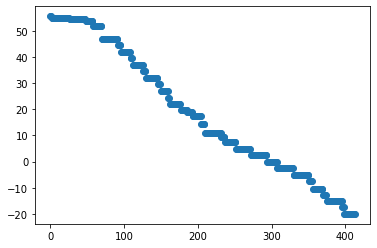

In [13]:
plt.scatter(
    np.arange(len(ompa_problem.obs_df)),
    ompa_problem.obs_df["latitude"])
plt.show()

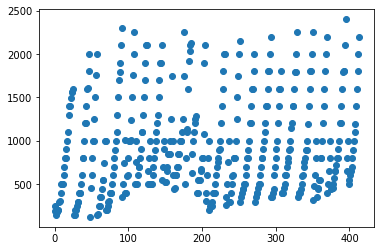

In [14]:
plt.scatter(
    np.arange(len(ompa_problem.obs_df)),
    ompa_problem.obs_df["depth"])
plt.show()

Thermocline Analysis

In [15]:
#Thermocline files include endmembers in the range of potential density 22 to 28 
#the Thomson and Krassovski (2010) definition of PSUW (better performing in previous version of the model) could not have its thermocline potnetial density range expanded
#likely due to lack of observation in the lower potential density range 
#the Tomczak and Godfrey (2003) definition of PSUW was used to obtain the 22-28 range 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u' -O ENPCW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Poki02WafLnFpuc196IFOCgdQVQt_yIs' -O PSUW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11cJgzVjT98Mkf_vB0gRSzCOTrEbxmz5i' -O ESSW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1S9QDgIisrGRtST9EXvAMG6lO4Q1XBG3E' -O SPCW_Den22to28_Oct2020_siderealPV_NO.csv

--2020-11-16 16:10:00--  https://docs.google.com/uc?export=download&id=1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u
Resolving docs.google.com (docs.google.com)... 172.217.204.138, 172.217.204.100, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ctll7rr4cg19oghplfqib4jssi1onmvk/1605543000000/06203730782251856755/*/1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u?e=download [following]
--2020-11-16 16:10:00--  https://doc-0o-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ctll7rr4cg19oghplfqib4jssi1onmvk/1605543000000/06203730782251856755/*/1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u?e=download
Resolving doc-0o-a4-docs.googleusercontent.com (doc-0o-a4-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-0o-a4-docs.googleusercontent.com (doc-0o

In [16]:
import pandas as pd

endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
endmemname_to_df ={}

for endmemname in endmemname_to_csv:
  # df=endmemname
  # print(df)
  csv = endmemname_to_csv[endmemname]
  print(csv)
  df = pd.read_csv(csv,names=header, na_values = -999)
  augment_df_with_PO_NO_SiO(df)
  df["watermassname"] = endmemname
  print(df.columns)
  endmemname_to_df[endmemname] = df; 

print(endmemname_to_df["ESSW"])     

PSUW_Den22to28_Oct2020_siderealPV_NO.csv
Index(['stnnbr', 'c2', 'c3', 'c4', 'bottle flag', 'geotrc_ID', 'c7', 'c8',
       'latitude', 'longitude', 'bottom depth', 'CTD pressure',
       'CTD temperature', 'c14', 'c15', 'practical_salinity',
       'bottle salinity flag', 'c18', 'c19', 'oxygen', 'bottle oxygen flag',
       'silicate', 'silicate flag', 'nitrate', 'nitrate flag', 'c26', 'c27',
       'phosphate', 'phosphate flag', 'PO', 'NO', 'SiO', 'watermassname'],
      dtype='object')
ENPCW_Den22to28_Oct2020_siderealPV_NO.csv
Index(['stnnbr', 'c2', 'c3', 'c4', 'bottle flag', 'geotrc_ID', 'c7', 'c8',
       'latitude', 'longitude', 'bottom depth', 'CTD pressure',
       'CTD temperature', 'c14', 'c15', 'practical_salinity',
       'bottle salinity flag', 'c18', 'c19', 'oxygen', 'bottle oxygen flag',
       'silicate', 'silicate flag', 'nitrate', 'nitrate flag', 'c26', 'c27',
       'phosphate', 'phosphate flag', 'PO', 'NO', 'SiO', 'watermassname'],
      dtype='object')
ESSW_Den22to2

In [17]:

def read_in_thermocline_endmemberdfs(endmemname_to_csv):
    #This function reads in the data frames for the thermocline end members
    #It takes endmemname_to_csv as input, which maps the thermocline
    # end member name (e.g. ENPCW) to the corresponding csv file.
    endmemname_to_df = {}
    #iterate through every endmemname in endmemname_to_csv
    #Order of thermocline endmember file columns: Sig0 pt SP O Si N P PO Pres spic0 vor NO Lat Lon T]);
    #e.g.
    header = ["c"+str(i) for i in range(1,17)] 
    header[0] = "sig0" #potential density 
    header[1] = "potential_temp"
    header[2] = "practical_salinity"
    header[3] = "oxygen"
    header[4] = "silicate"
    header[5] = "nitrate"
    header[6] = "phosphate"
    header[7] = "PO" #remove if calculating this later?
    header[8] = "CTD pressure"
    header[9] = "spiciness" #spiciness
    header[10] = "PV" #potential vorticity
    header[11] = "NO" #remove if calculating this later?
    header[12] = "latitude"
    header[13] = "longitude"
    header[14] = "CTD temperature"
    #make sure header names are compatible
    # with those used in the prepare_water_mass_df function defined earlier
    # for intermediate waters.
    for endmemname in endmemname_to_csv.keys():
      #get the csv file corresponding to the endmemname
      csv = endmemname_to_csv[endmemname]
      #read the csv file into a data frame df
      df = pd.read_csv(csv,names=header, na_values = -999)
      augment_df_with_PO_NO_SiO(df)
      #Also add a column to the df that just has the end member name
      # repeated for each row. This will come in handy later when
      # pairing rows from different data frames
      df["watermassname"] = endmemname
      #store df in endmemname_to_df with the key endmemname
      endmemname_to_df[endmemname] = df; 

    return endmemname_to_df


def get_endmember_df_for_sig0_range(endmemnames_to_use,
                                    endmemname_to_df,
                                    sig0_bin_start,
                                    sig0_bin_end):
  #Idea: for each entry in endmemname_to_df, filter out the row
  # that lies within sig0_bin_start and sig0_bin_end (there should
  # only be one such row). Then assemble all those rows into a data frame
  # of the endmembers to use for the OMPA analysis, for that sig0 range
  
  #We'll create a list of the correct rows from each pandas df
  correct_rows = []
  sig0_bin_start = np.round(sig0_bin_start, decimals=2)
  sig0_bin_end = np.round(sig0_bin_end, decimals=2)
  for endmemname in endmemnames_to_use: #iterate through the endmembers to use
    #apply a filtering to endmemname_to_df to get the right row corresponding
    # to the sig0 range
    df = endmemname_to_df[endmemname]
    correct_rows_for_endmemname =\
    df[(df["sig0"] >= sig0_bin_start) & (df["sig0"] < sig0_bin_end)]
    #correct_rows_for_endmemname is a (view of a) data frame. It should
    # have a length of 1 (there should be only one row for each sig0 bin),
    # so let's verify that with an 'assert' statement.
    assert len(correct_rows_for_endmemname)==1 #will throw error if not true
    #Store the row from this end member dataframe in the list of correct rows
    correct_rows.append(correct_rows_for_endmemname)  
    #print(correct_rows_for_endmemname) 
  #Now we just have to concatenate 'correct_rows' into a single
  # pandas DataFrame; pandas should take care of matching up the
  # columns correctly.
  #this should work, but I haven't used pd.concat often so I'm not 100% sure
  paired_up_endmember_df = pd.concat(correct_rows) 

  return paired_up_endmember_df

#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)


In [18]:
print("First ten rows")
!head "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"
print("last ten rows")
!tail "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"

First ten rows
22,64.431,42.697,6.2569,85.31,54.442,4.7607,804.22,-68.018,18.211,9.9471e-08,716.82,-72.15,-80.999,64.427
22.01,63.657,42.508,10.37,84.011,53.425,4.6727,793.96,-66.984,17.912,9.7867e-08,708.26,-69.988,-82.148,63.652
22.02,62.89,42.322,14.441,82.725,52.42,4.5856,783.83,-65.959,17.616,9.628e-08,699.8,-67.85,-83.283,62.886
22.03,62.132,42.138,18.47,81.453,51.426,4.4996,773.81,-64.944,17.323,9.4709e-08,691.44,-65.734,-84.407,62.127
22.04,61.381,41.956,22.456,80.195,50.444,4.4145,763.91,-63.939,17.034,9.3154e-08,683.17,-63.642,-85.517,61.377
22.05,60.638,41.776,26.401,78.951,49.472,4.3305,754.13,-62.943,16.747,9.1616e-08,675,-61.573,-86.615,60.634
22.06,59.903,41.598,30.303,77.72,48.513,4.2474,744.47,-61.957,16.464,9.0094e-08,666.93,-59.526,-87.701,59.899
22.07,59.175,41.422,34.164,76.503,47.564,4.1654,734.93,-60.981,16.183,8.8589e-08,658.95,-57.502,-88.775,59.171
22.08,58.455,41.248,37.984,75.3,46.626,4.0843,725.5,-60.014,15.906,8.7099e-08,651.07,-55.501,-89.836,58.451
22.09

In [19]:
#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)

#Define thermocline
#By convention, constants are in all caps
TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5
TC_STEP = 0.01
therm_endmem_to_use = ["PSUW","ENPCW","ESSW", "SPCW"] #thermocline water masses for analysis
# members to use in the analysis 
gp15_thermocline = gp15_df[(gp15_df["sig0"] >= TC_LOWER_BOUND)
                            & (gp15_df["sig0"] <= TC_UPPER_BOUND)]

thermocline_paramsandweighting = [("potential_temp",200),
                                   ("practical_salinity",155),
                                   ("silicate",5),
                                   #("NO",10),
                                   ("PO",10),
                                   ("spiciness",10),
                                   #("PV",10),
                                   ]

#thermocline_ompa_results is a list that will store the results of the OMPA
# for each sig0 interval
thermocline_ompa_results = []
for sig0_bin_start in np.arange(TC_LOWER_BOUND, TC_UPPER_BOUND, TC_STEP):
    sig0_bin_end = sig0_bin_start + TC_STEP
    #Get the endmember dataframe for OMPA analysis corresponding to the
    #sig0 range - the logic for pairing different end members will happen
    # in this function.
    endmember_df_for_sig0_range =\
      get_endmember_df_for_sig0_range(
          endmemnames_to_use=therm_endmem_to_use,
          endmemname_to_df=endmemname_to_df,
          sig0_bin_start=sig0_bin_start,
          sig0_bin_end=sig0_bin_end)
    # It would be good, when testing, to print out paired_up_endmember_df
    # and make sure that things look good visually, to be sure.
    #print(paired_up_endmember_df)
    obs_df_for_sig0_range = gp15_thermocline[
                            (gp15_thermocline["sig0"] >= sig0_bin_start)
                            & (gp15_thermocline["sig0"] <= sig0_bin_end)] #filter gp15_thermocline using sig0_bin_start and sig0_bin_end
    if (len(obs_df_for_sig0_range)==0):
      print("No observations for range", sig0_bin_start, sig0_bin_end)
      continue #skip this iteration of the loop
    
    #Now that you have the data frames for the observations and end members,
    # you can define the ompa problem
    ompa_problem = OMPAProblem(
              watermass_df = endmember_df_for_sig0_range,
              obs_df = obs_df_for_sig0_range, 
              paramsandweighting=thermocline_paramsandweighting,
              smoothness_lambda=None)
              ### Or are 0.01 increments already doing this? ###
    ompa_problem.solve()
    print(ompa_problem.prob.status)
    if (ompa_problem.prob.status is not "infeasible"):
        thermocline_ompa_results.append(ompa_problem)
    else:
        print("Warning! Infeasible for:")
        print("obs df:")
        cols_to_print = [x[0] for x in thermocline_paramsandweighting]+["sig0"]
        print(obs_df_for_sig0_range[cols_to_print])
        print("water mass df:")
        print(endmember_df_for_sig0_range[cols_to_print])
    #columns.df to get column names

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'PO', 'spiciness']
param weighting: [200 155   5  10  10]
status: optimal
optimal value 775.916123899841
objective: 775.9161558630618
optimal
No observations for range 25.51 25.520000000000003
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'PO', 'spiciness']
param weighting: [200 155   5  10  10]
status: optimal
optimal value 12662.730050831495
objective: 12662.73277751622
optimal
No observations for range 25.530000000000005 25.540000000000006
No observations for range 25.540000000000006 25.550000000000008
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'PO', 'spiciness']
param weighting: [200 155   5  10  10]
status: optimal
optimal value 21436.93261294012
objective: 21436.935894938848
optimal
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'PO', 'spiciness']
param weighting: [200 155   5  10  10]
status: optimal
optimal value 87980.01042523149
objective: 87

In [20]:
thermocline_ompa_results[0].param_residuals.shape

(1, 5)

In [21]:
thermocline_ompa_results[50].water_mass_fractions

array([[ 1.40174423e-01,  8.59825577e-01, -1.33750729e-11,
        -8.77578178e-12],
       [ 1.83108633e-01,  6.70618463e-01,  2.94201146e-13,
         1.46272904e-01],
       [ 1.17634540e-01, -3.78673899e-11,  8.82365461e-01,
        -2.80214589e-11]])

Visualization of Thermocline 

Plotting water mass fractions
Number of points: (120, 4)


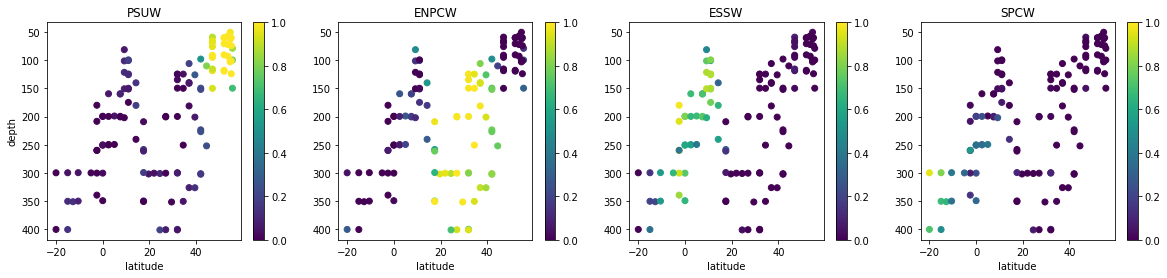

In [22]:

def plot_thermocline_water_mass_fractions(ompa_problems_arr, yaxis="depth"):
    #first, check to make sure all entries in ompa_problems_arr have the same
    # number of water masses; the assert statement will throw an error if
    # that is not the case
    num_watermasses = ompa_problems_arr[0].water_mass_fractions.shape[1]
    assert all([x.water_mass_fractions.shape[1]==num_watermasses
                for x in ompa_problems_arr])
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    
    water_mass_fractions = np.concatenate([
            x.water_mass_fractions for x in ompa_problems_arr], axis=0)
    latitudes = np.concatenate([
            np.array(x.obs_df["latitude"]) for x in ompa_problems_arr])
    yaxis_vals = np.concatenate([
        np.array(x.obs_df[yaxis]) for x in ompa_problems_arr])
        
    print("Number of points:", water_mass_fractions.shape)

    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(latitudes,
                    yaxis_vals,
                    c=water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        plt.clim(0,1)
        plt.title(list(ompa_problems_arr[0].watermass_df["watermassname"])[i])
    plt.show()

print("Plotting water mass fractions")
plot_thermocline_water_mass_fractions(thermocline_ompa_results[:])

#print("Plotting absolute residuals")
#for setting in ompa_setting_to_soln:
#    print("Setting:", setting)
#    plot_residuals(ompa_setting_to_soln[setting])  

In [23]:
np.sum(thermocline_ompa_results[2].water_mass_fractions, axis=1)

array([0.99999999, 1.        ])

Plotting parameter residuals
Number of points: (120, 5)


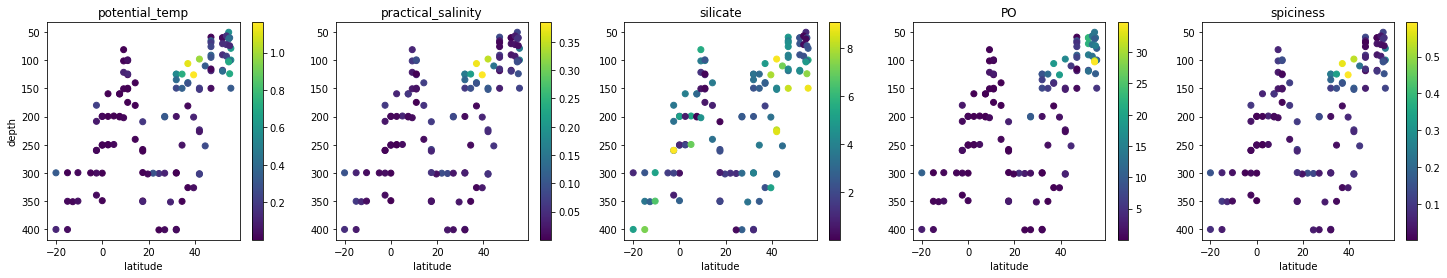

In [24]:
def plot_thermocline_residuals(ompa_problems_arr, yaxis="depth"):
    num_params = ompa_problems_arr[0].param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    
    param_residuals = np.concatenate([
            x.param_residuals for x in ompa_problems_arr], axis=0)
    latitudes = np.concatenate([
            np.array(x.obs_df["latitude"]) for x in ompa_problems_arr])
    yaxis_vals = np.concatenate([
        np.array(x.obs_df[yaxis]) for x in ompa_problems_arr])
        
    print("Number of points:", param_residuals.shape)

    for i in range(num_params):
        plt.sca(ax[i])
        plt.scatter(latitudes,
                    yaxis_vals,
                    #c=param_residuals[:,i]) #uncomment to have neg and pos residuals 
                    c=np.abs(param_residuals[:,i]))
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        #plt.clim(0,10)
        #plt.title(list(ompa_problems_arr[0].params_to_use[i]))
        plt.title(ompa_problems_arr[0].params_to_use[i])
plt.show()

print("Plotting parameter residuals")
plot_thermocline_residuals(thermocline_ompa_results[:])



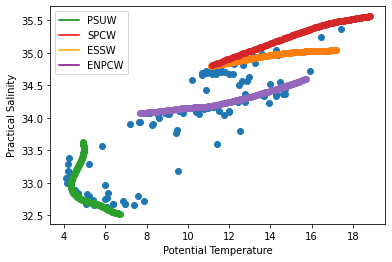

In [25]:
plt.scatter(gp15_thermocline["potential_temp"],
                    gp15_thermocline["practical_salinity"])
ESSW = endmemname_to_df["ESSW"][
                            (endmemname_to_df["ESSW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["ESSW"]["sig0"] <= TC_UPPER_BOUND)] 
PSUW = endmemname_to_df["PSUW"][
                            (endmemname_to_df["PSUW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["PSUW"]["sig0"] <= TC_UPPER_BOUND)] 
SPCW = endmemname_to_df["SPCW"][
                            (endmemname_to_df["SPCW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["SPCW"]["sig0"] <= TC_UPPER_BOUND)] 
ENPCW = endmemname_to_df["ENPCW"][
                            (endmemname_to_df["ENPCW"]["sig0"] >= TC_LOWER_BOUND)
                            & (endmemname_to_df["ENPCW"]["sig0"] <= TC_UPPER_BOUND)] 
plt.scatter(ESSW["potential_temp"], ESSW["practical_salinity"])
plt.scatter(PSUW["potential_temp"], PSUW["practical_salinity"])
plt.scatter(SPCW["potential_temp"], SPCW["practical_salinity"])
plt.scatter(ENPCW["potential_temp"], ENPCW["practical_salinity"])
plt.xlabel("Potential Temperature")
plt.ylabel("Practical Salinity")
import matplotlib.lines as mlines
green_line = mlines.Line2D([], [],color='green', label='PSUW')
red_line = mlines.Line2D([], [],color='red', label='SPCW')
orange_line = mlines.Line2D([], [],color='orange', label='ESSW')
purple_line = mlines.Line2D([], [],color='purple', label='ENPCW')
plt.legend(handles=[green_line, red_line, orange_line, purple_line])
plt.show()

In [38]:


def build_thermocline_altair_viz(ompa_problems_arr):

    #verify watermass names are the same for all
    watermass_names = tuple(ompa_problems_arr[0].watermass_df["watermassname"])
    assert all(tuple(x.watermass_df["watermassname"])==watermass_names
               for x in ompa_problems_arr)
    param_names = tuple(ompa_problems_arr[0].params_to_use)
    assert all(tuple(x.params_to_use)==param_names
               for x in ompa_problems_arr)

    #concatenate all the observations to get a new obs_df
    altairdf = pd.concat([x.obs_df for x in ompa_problems_arr])

    for water_mass_idx in range(ompa_problems_arr[0]
                                .water_mass_fractions.shape[1]):
      altairdf[watermass_names[water_mass_idx]] = np.concatenate([
        x.water_mass_fractions[:,water_mass_idx]
        for x in ompa_problems_arr])

    for param_idx in range(ompa_problem.param_residuals.shape[1]):
        param_name = param_names[param_idx]
        altairdf[param_name+"_resid"] = np.concatenate([
          x.param_residuals[:,param_idx] for x in ompa_problems_arr])          

    interval_selection = alt.selection_interval()
    tooltip_columns = (list(param_names)
                       + ["latitude", "longitude"]
                       + list(watermass_names)
                       + [x+"_resid" for x in ompa_problem.params_to_use])
    
    #make the linked property-property plots
    obs_basechart = alt.Chart(altairdf).mark_point().encode(
      tooltip=tooltip_columns,
      color=alt.condition(interval_selection,
                          alt.value("lightblue"),#"NPIW",
                          alt.value('lightgray'))
      ).add_selection(interval_selection).properties(
          width=CHART_WIDTH,
          height=CHART_HEIGHT)
    
    #prepare a watermass df
    watermass_df = pd.concat([x.watermass_df for x in ompa_problems_arr])

    watermass_basechart =\
      alt.Chart(watermass_df).mark_point(
          shape="diamond", size=50).encode(
              tooltip=list(param_names),
              color="watermassname").properties(
                width=CHART_WIDTH,
                height=CHART_HEIGHT)

    #display a row that is the water mass fractions
    watermass_fraction_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf)
        for property_name in watermass_names]

    the_pp_scatterplots = []
    for i in range(len(ompa_problem.params_to_use)):
        for j in range(i+1,len(ompa_problem.params_to_use)):
            the_pp_scatterplots.append(
                pp_scatterplot(
                    obs_basechart=obs_basechart,
                    selection=interval_selection,
                    watermass_basechart=watermass_basechart,
                    property1=ompa_problem.params_to_use[i],
                    property2=ompa_problem.params_to_use[j],
                    opacity=1)
            )
    
    resid_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name+"_resid",
            altairdf=altairdf,
            zerocenter=True)
        for property_name in ompa_problem.params_to_use]

    prop_scatterplots = [
        latdepth_scatterplot(
            basechart=obs_basechart,
            selection=interval_selection,
            property_name=property_name,
            altairdf=altairdf,
            zerocenter=True)
        for property_name in ompa_problem.params_to_use]

    return alt.vconcat(
              wrap_scatterplots(watermass_fraction_scatterplots),
              wrap_scatterplots(prop_scatterplots, resolve_scale="independent"),
              wrap_scatterplots(resid_scatterplots,
                                resolve_scale='independent'),
              wrap_scatterplots(the_pp_scatterplots))
    

build_thermocline_altair_viz(thermocline_ompa_results)

alt.VConcatChart(...)